## 1) Introduction and Goals

This notebook demonstrates a comparison between:
1. A **standard Gaussian Process** using scikit-learn (SE kernel).
2. A **vanilla feedforward Neural Network** in PyTorch.
3. A **Deep Kernel Learning** approach, which combines a small neural net feature extractor with a Gaussian Process kernel in GPyTorch.

We'll tackle a **1D toy regression** problem. Our function will be nonlinear so we can see differences in how each method extrapolates and estimates uncertainty.


In [89]:
# %pip install numpy, matplotlib.pyplot 
# %pip install sklearn.gaussian_process.kernels, sklearn.gaussian_process,
# %pip install torch
# %pip install gpytorch
# %pip install plotly

In [90]:
# [1]: Imports and basic setup

import numpy as np
import matplotlib.pyplot as plt

# For standard GP
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

# For NN
import torch
import torch.nn as nn
import torch.optim as optim

# For DKL using gpytorch
import gpytorch
from gpytorch.mlls import VariationalELBO
from gpytorch.likelihoods import GaussianLikelihood

# Misc
np.random.seed(43)
torch.manual_seed(43)


## 2) Dataset Generation

We'll create a simple 1D function with some nonlinear behavior:
$y = \\sin(2 x) + 0.3 x^3 + \text{noise}$

We'll sample from $x$ in the range $[-3, 3]$. We'll generate a training set and a separate testing grid for evaluation.


In [91]:
# In[2]: Generate synthetic data

def true_function(x):
    # Nonlinear function of x
    return np.sin(2*x) + 0.3*(x**3)

N_train = 40
N_test  = 200
X_min, X_max = -3.0, 3.0

# Training data
X_train = np.random.uniform(X_min, X_max, size=(N_train, 1))
y_train_true = true_function(X_train.ravel())
noise_std = 0.4
y_train = y_train_true + noise_std*np.random.randn(N_train)

# Testing data (regular grid)
X_test = np.linspace(X_min, X_max, N_test).reshape(-1, 1)
y_test_true = true_function(X_test.ravel())

print("Shapes -> X_train:", X_train.shape, "y_train:", y_train.shape)
print("           X_test:", X_test.shape,  "y_test_true:", y_test_true.shape)


Shapes -> X_train: (40, 1) y_train: (40,)
           X_test: (200, 1) y_test_true: (200,)


In [92]:
# # Define the McCormick function
# def mccormick(x1, x2):
#     return np.sin(x1 + x2) + (x1 - x2)**2 - 1.5 * x1 + 2.5 * x2 + 1

# # Generate grid data for plotting
# x1 = np.linspace(-1.5, 4, 100)
# x2 = np.linspace(-3, 4, 100)
# x1_test, x2_test = np.meshgrid(x1, x2)
# y = mccormick(x1_test, x2_test)

# # # Generate test data
# test_x = torch.tensor(np.vstack((x1_test.ravel(), x2_test.ravel())).T, dtype=torch.float32)
# test_y = torch.tensor(y.ravel(), dtype=torch.float32)

# # Generate training data
# x1 = np.linspace(-1.5, 4, 5)
# x2 = np.linspace(-3, 4, 5)
# x1_train, x2_train = np.meshgrid(x1, x2)
# train_x = np.vstack((x1_train.ravel(), x2_train.ravel())).T
# # add noise to the training data
# train_y = mccormick(train_x[:, 0], train_x[:, 1]) + np.random.normal(0, 1, len(train_x))

# # # Convert training data to tensors
# # train_x = torch.tensor(train_x, dtype=torch.float32)
# # train_y = torch.tensor(train_y.ravel(), dtype=torch.float32)

# X_test = test_x
# y_test_true = test_y
# X_train = train_x
# y_train = train_y

## 3) Standard Gaussian Process (scikit-learn)

We'll use an RBF kernel with automatic length-scale.  
We also add some noise via `WhiteKernel` to handle the variance of the data.

**Key points**:
- The GP can learn lengthscales and noise level from data.
- We get posterior mean and standard deviation at test points, which we can plot to see uncertainty bands.


In [93]:
# In[3]: Fit a standard Gaussian Process

# Define an RBF kernel + WhiteKernel for noise
kernel = RBF(length_scale=1.0) + WhiteKernel(noise_level=1.0)

gp_model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, alpha=0.0)
gp_model.fit(X_train, y_train)

print("Learned kernel:", gp_model.kernel_)
print("Log-marginal-likelihood:", gp_model.log_marginal_likelihood_value_)


Learned kernel: RBF(length_scale=0.558) + WhiteKernel(noise_level=0.318)
Log-marginal-likelihood: -75.6394519655774


In [94]:
y_train.shape, X_train.shape

((40,), (40, 1))

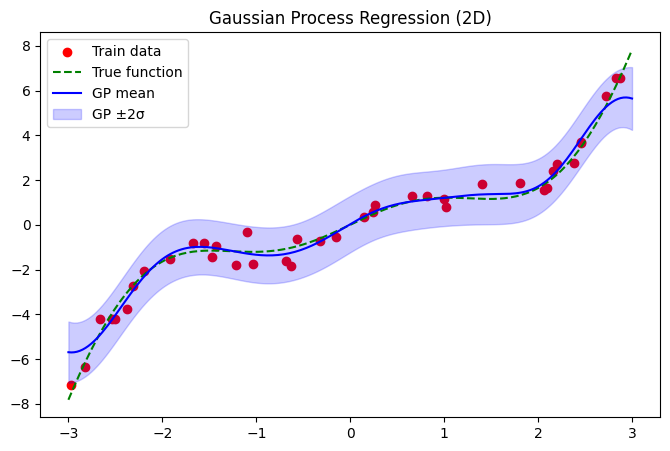

In [95]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Predict GP mean and standard deviation
y_gp_mean, y_gp_std = gp_model.predict(X_test, return_std=True)

# Check if data is 2D or 3D
is_3d = X_train.shape[1] == 2 if len(X_train.shape) > 1 else False

if is_3d:
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Scatter training data
    ax.scatter(X_train[:, 0], X_train[:, 1], y_train, c='r', label='Train data')

    # Plot true function
    ax.plot_trisurf(X_test[:, 0], X_test[:, 1], y_test_true, color='g', alpha=0.3, label='True function')

    # Plot GP mean prediction
    ax.plot_trisurf(X_test[:, 0], X_test[:, 1], y_gp_mean, color='b', alpha=0.5, label='GP mean')

    # Uncertainty visualization using a wireframe (±2σ)
    ax.plot_trisurf(X_test[:, 0], X_test[:, 1], y_gp_mean - 2*y_gp_std, color='blue', alpha=0.2)
    ax.plot_trisurf(X_test[:, 0], X_test[:, 1], y_gp_mean + 2*y_gp_std, color='blue', alpha=0.2)

    ax.set_title("Gaussian Process Regression (3D)")
    ax.set_xlabel("X1")
    ax.set_ylabel("X2")
    ax.set_zlabel("y")
    # plot legend in best location
    ax.legend(loc='best')

else:
    plt.figure(figsize=(8, 5))
    plt.scatter(X_train, y_train, c='r', label='Train data')
    plt.plot(X_test, y_test_true, 'g--', label='True function')
    plt.plot(X_test, y_gp_mean, 'b', label='GP mean')
    plt.fill_between(X_test.ravel(),
                     y_gp_mean - 2*y_gp_std,
                     y_gp_mean + 2*y_gp_std,
                     alpha=0.2, color='blue', label='GP ±2σ')
    plt.title("Gaussian Process Regression (2D)")
    # plot legend in best location
    plt.legend(loc='best')

plt.show()


## 4) Vanilla Neural Network (PyTorch)

We'll build a simple fully connected network:
- Input -> Dense(64, ReLU) -> Dense(64, ReLU) -> Dense(1)
- Train with MSE loss, using Adam optimizer.

We won't model predictive uncertainty in a Bayesian sense, so we'll just get a single best-fit curve. 


In [96]:
# In[5]: Define a simple feedforward neural network

class SimpleNet(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64):
        super(SimpleNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
    def forward(self, x):
        return self.net(x)

# Instantiate
nn_model = SimpleNet(input_dim=1, hidden_dim=64)

criterion = nn.MSELoss()
optimizer = optim.Adam(nn_model.parameters(), lr=0.01)


### Training loop for the Neural Network
We'll train for a modest number of epochs (e.g. 2000).


In [97]:
# In[6]: Train the network

X_train_t = torch.from_numpy(X_train).float()
y_train_t = torch.from_numpy(y_train).float().view(-1, 1)

n_epochs = 2000
for epoch in range(n_epochs):
    nn_model.train()
    optimizer.zero_grad()
    
    y_pred = nn_model(X_train_t)
    loss = criterion(y_pred, y_train_t)
    loss.backward()
    optimizer.step()
    
    # Print progress occasionally
    if (epoch+1) % 500 == 0:
        print(f"Epoch {epoch+1}/{n_epochs}, Loss={loss.item():.4f}")


Epoch 500/2000, Loss=0.1097
Epoch 1000/2000, Loss=0.0947
Epoch 1500/2000, Loss=0.0925
Epoch 2000/2000, Loss=0.0941


In [98]:
X_test.shape

(200, 1)

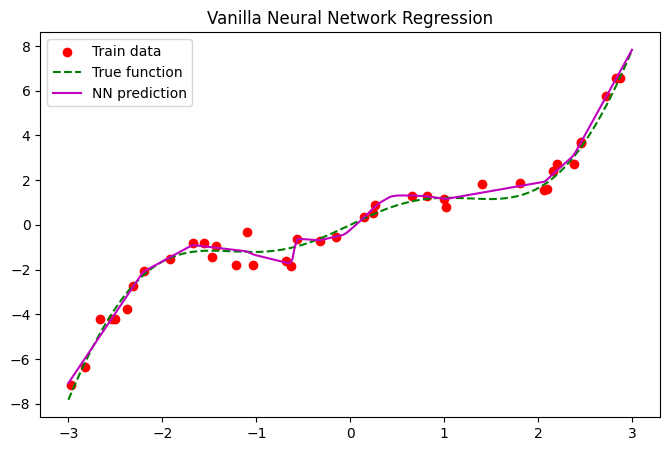

In [99]:
# In[7]: Predict with the trained NN and plot

nn_model.eval()
X_test_t = torch.from_numpy(X_test).float()
with torch.no_grad():
    y_nn_pred = nn_model(X_test_t).numpy().ravel()

plt.figure(figsize=(8,5))
plt.scatter(X_train, y_train, c='r', label='Train data')
plt.plot(X_test, y_test_true, 'g--', label='True function')
plt.plot(X_test, y_nn_pred, 'm', label='NN prediction')
plt.title("Vanilla Neural Network Regression")
plt.legend()
plt.show()


## 5) Deep Kernel Learning (DKL) 


In [100]:
import numpy as np
import torch
import gpytorch
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import pandas as pd
from torch import nn
from plotly.subplots import make_subplots
from sklearn.metrics import mean_squared_error

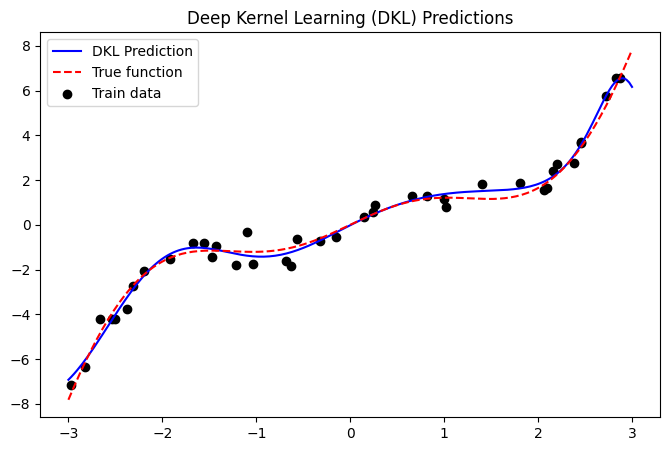

In [104]:
# Convert to tensors
train_x = torch.tensor(X_train, dtype=torch.float32)
train_y = torch.tensor(y_train, dtype=torch.float32)
test_x = torch.tensor(X_test, dtype=torch.float32)
test_y = torch.tensor(y_test_true, dtype=torch.float32)

# Define DNN feature extractor
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.fc1 = nn.Linear(1, 8)
        self.fc2 = nn.Linear(8, 4)
        self.fc3 = nn.Linear(4, 2)
        self.activation = nn.Softplus()
    
    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x

# Define DKL model
class DKLModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(DKLModel, self).__init__(train_x, train_y, likelihood)
        self.feature_extractor = FeatureExtractor()
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
    
    def forward(self, x):
        projected_x = self.feature_extractor(x)
        mean_x = self.mean_module(projected_x)
        covar_x = self.covar_module(projected_x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)



# Initialize likelihoods and models
dkl_likelihood = gpytorch.likelihoods.GaussianLikelihood()
dkl_model = DKLModel(train_x, train_y, dkl_likelihood)

# Training parameters
training_iterations = 500

# Train DKL model
dkl_model.train()
dkl_likelihood.train()
optimizer = torch.optim.Adam([
    {'params': dkl_model.feature_extractor.parameters()},
    {'params': dkl_model.covar_module.parameters()},
    {'params': dkl_model.mean_module.parameters()},
    {'params': dkl_likelihood.parameters(), 'lr': 0.05},
], lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(dkl_likelihood, dkl_model)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)

for i in range(training_iterations):
    optimizer.zero_grad()
    output = dkl_model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()
    scheduler.step()


# Evaluate models
dkl_model.eval()
dkl_likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    dkl_pred = dkl_likelihood(dkl_model(test_x))

dkl_pred = dkl_pred.mean.numpy()
true_y = test_y.numpy()

# Create interactive plots
fig = go.Figure()

# DKL predictions
fig.add_trace(go.Scatter(x=X_test.ravel(), y=dkl_pred, mode='lines', name='DKL Prediction', line=dict(color='blue')))

# True function
fig.add_trace(go.Scatter(x=X_test.ravel(), y=true_y, mode='lines', name='True Function', line=dict(color='red')))

# Training points
fig.add_trace(go.Scatter(x=train_x.numpy().ravel(), y=train_y.numpy(), mode='markers', name='Train Points', marker=dict(color='black', size=5)))

fig.update_layout(title='DKL Predictions on Synthetic Data', xaxis_title='X', yaxis_title='Y')
fig.show()

# also plot using matplotlib
plt.figure(figsize=(8,5))
plt.plot(X_test, dkl_pred, 'b', label='DKL Prediction')
plt.plot(X_test, true_y, 'r--', label='True function')
plt.scatter(X_train, y_train, c='k', label='Train data')
plt.title("Deep Kernel Learning (DKL) Predictions")
plt.legend()
plt.show()



## 6) Comparison and Discussion

We've now seen:
1. **Standard GP**: Learns a lengthscale and noise, yields smooth function + uncertainty.  
2. **Vanilla NN**: Flexible, but doesn't give uncertainty intervals out of the box.  
3. **DKL**: Combines a neural net front-end with a GP in latent space, capturing more complex relationships while retaining GP-based uncertainty.

Below, let's compute a quick RMSE on test data for each approach.


In [102]:
dkl_mse = mean_squared_error(test_y.numpy(), dkl_pred.ravel())
gp_mse = mean_squared_error(test_y.numpy(), y_gp_mean)
nn_mse = mean_squared_error(y_test_true, y_nn_pred)


df = pd.DataFrame({'Model': ['DKL', 'GP', 'NN'],
                   'MSE': [dkl_mse, gp_mse, nn_mse]
                   })
df

,Model,MSE
0,DKL,0.035493
1,GP,0.165852
2,NN,0.071081


# # 7) Conclusions / Next Steps

- **Standard GP** performed well for this 1D case, with good uncertainty intervals but potentially limited if we had high-dimensional data.
- **Vanilla NN** can capture nonlinearity but doesn't give straightforward uncertainty. Performance depends on network architecture and training.
- **DKL** can learn a richer latent representation than a standard GP, potentially improving performance on more complex data, while still giving a GP posterior for uncertainty.

**Further directions**:
- Use larger or more complex data (e.g., 2D or higher-dimensional). 
- Explore hyperparameter tuning, e.g., different net widths, #inducing points, etc. 
- Evaluate run-time complexity for big datasets, considering sparse GP approximations or mini-batching.